# Early Stopping Criteria & Weight loading

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tensorchiefs/dl_course_2025/blob/master/notebooks/07_1_training_criteria.ipynb)

**Task:**
In this Notebook you will see how early stopping is implemented to prevent overfitting and avoid uneccessary computational cost, aswell as how modelweights are loaded into a new modelinstance e.g. for further training .


**Dataset:** We simulate some data

**Content:**
- Sample some Classification Data
- Define early stopping with patience
- Define model callback to save the weights
- Fit the model and check out when it stopped
- Restore a model and load the weights from the previous model

In [1]:
# load required libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
import torch
import pandas as pd

print(f'Keras_version: {keras.__version__}')# 3.5.0
print(f'torch_version: {torch.__version__}')# 2.5.1+cu121
print(f'keras backend: {keras.backend.backend()}')


import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

Keras_version: 3.8.0
torch_version: 2.6.0+cu124
keras backend: torch


- lets create some data:

In [2]:
X, y = make_classification(n_samples=2000, n_features=20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

(1600, 20)


- create a simple model:

In [3]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Input Layer using Input()
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [4]:
## Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,                # <- how long are we waiting after the validation loss at epoch t was worse than t-1
    verbose=1,
    restore_best_weights=False  # <- set to true if at the end of the training the model should restore the best weights based on the monitor
)

## ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    filepath='best_model_weights.weights.h5',  #
    monitor='val_loss',
    save_best_only=True,     # <- save only the best weights according to the monitoring
    save_weights_only=True,  # <- only the weigths not the whole model
    verbose=1
)

In [5]:
# Training the Model with Early Stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6279 - loss: 0.6390
Epoch 1: val_loss improved from inf to 0.45299, saving model to best_model_weights.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6328 - loss: 0.6343 - val_accuracy: 0.8225 - val_loss: 0.4530
Epoch 2/50
47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8377 - loss: 0.4025
Epoch 2: val_loss improved from 0.45299 to 0.33175, saving model to best_model_weights.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8393 - loss: 0.3993 - val_accuracy: 0.8775 - val_loss: 0.3318
Epoch 3/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8824 - loss: 0.3057
Epoch 3: val_loss improved from 0.33175 to 0.28959, saving model to best_model_weights.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8823 - loss: 0.3054 - val_accuracy: 0.8975 - val_loss: 0.2896
Epoch 4/50
47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8834 - loss: 0.2807
Epoch 4: val_loss improved 

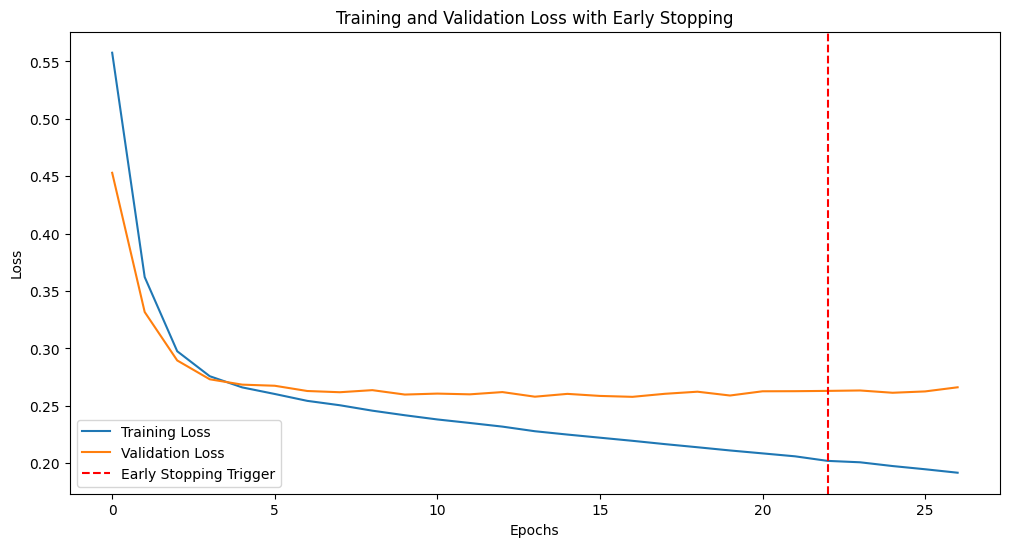

In [6]:
# Plotting Training History
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axvline(len(history.history['val_loss']) - 5, color='r', linestyle='--', label='Early Stopping Trigger')
plt.title('Training and Validation Loss with Early Stopping')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## instantiate another model and load the weights from the training before

In [7]:
# Defining the Sequential Model with an Input Layer
model2 = Sequential([
    Input(shape=(X_train.shape[1],)),  # Input Layer using Input()
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile again
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Calculating the validation loss directly using the model's loss function
val_loss_untrained, _ = model2.evaluate(X_val, y_val, verbose=0)

print(f"\nValidation Loss before weight loading: {val_loss_untrained:.6f}")


Validation Loss before weight loading: 0.699121


- now lets load the weights from the model 1 (same architecture)

In [8]:
# load the weights from the mdoel before
model2.load_weights('best_model_weights.weights.h5')

val_loss_laoded_weights, _ = model2.evaluate(X_val, y_val, verbose=0)

print(f"\nValidation Loss after loading the weights: {val_loss_laoded_weights:.6f}")


Validation Loss after loading the weights: 0.257900


# Summary

- use early stopping to prevent overfitting and avoid overly long trainingssessions.
- use modelcallback to save the weights and restore them e.g.  for further training or inference